# SCAnalysis for single cell RNA-seq

This notebook details the usage of SCAnalysis for single cell RNA-seq data.

To view directly: https://nbviewer.jupyter.org/github/helenjin/scanalysis/blob/master/notebooks/SCAnalysis.ipynb
*(ignore if already here)*

<a id="toc"></a>
## Table of Contents

1. [Introduction](#intro)
2. [Loading Data](#loading)
3. [Data Preprocessing](#preprocessing):
    *a. [Data Filtering](#filter)
    b. [Data Normalization](#norm)
    c. [PCA](#pca)
    d. [Diffusion maps](#dmap)
    e. [tSNE](#tsne)*
4. [Saving data](#savedata)
5. [General Plots](#genplot):
    *a. [PCA visualization](#pcavisual)
    b. [tSNE visualization](#tsnevisual)
    c. [Diffusion maps visualization](#dmvisual)*   
6. [Gene Set Enrichment Analysis (GSEA)](#gsea)
7. [Running Wishbone](#wishbone)
8. [Plotting Wishbone Results](#wbplot):
    *a.[Plot Wishbone on tSNE maps](#wb_on_tsne)
    b. [Plot Marker Trajectory](#plot_marker_traj)
    c. [Plot Marker Heatmap](#plot_marker_hmap)
    d.[Plot Derivatives](#plot_derivs)*
9. [Running MAGIC](#magic)
10. [Plotting MAGIC Results](#mgplot):
    *a. [PCA scatter plots](#magicpcaplots)
    b. [tSNE scatter plots](#magictsneplots)*
11. [Saving figures](#savefig)
12. [Running Palantir](#palantir)
13. [Plotting Palantir Results](#prplot):
    *a. [Plot Markers](#plot_markers)
    b. [Plot Palantir on tSNE](#pr_on_tsne)
    c. [Specific example](#ex)*
14. [References](#ref)

<a id="intro"></a>
## Introduction

SCAnalysis is a package for analyzing single cell data. It includes the Wishbone, MAGIC, and Palantir packages:

* Wishbone is an algorithm to identify bifurcating developmental trajectories from single cell data. Wishbone can applied to single cell RNA-seq (not currently supported for mass cytometry datasets)

* MAGIC (Markov-Affinity Based Graph Imputation of Cells) is an interactive tool to impute missing values in single-cell data and restore the structure of the data. It also provides data preprocessing functionality such as dimensionality reduction and gene expression visualization.

* Palantir 

<a id="loading"></a>
## Loading Data

First, import the package.

In [1]:
import scanalysis

Then, you can load the data using the load function in the loadsave file of the io folder. Here, we will be using the sample_scseq_data.csv data provided in the data folder as an example.

In [2]:
df = scanalysis.io.loadsave.load("~/scanalysis/data/sample_scseq_data.csv")

Successfully loaded /Users/hjin/scanalysis/data/sample_scseq_data.csv as a pd.DataFrame object


Also, import plotting and miscellaneous.

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

<a id="preprocessing"></a>
## Data preprocessing 

<a id="filter"></a>
### Data filtering

2.28555730901
4.07051809702


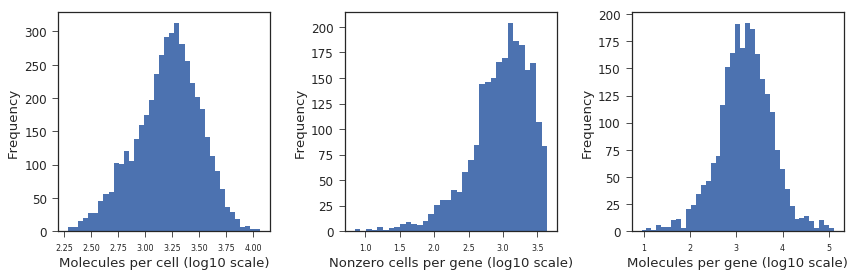

In [4]:
fig, ax = scanalysis.plots.plot.plot_molecules_per_cell_and_gene(df)

From these histograms, choose the appropriate cutoffs to filter the data. In this case, the data has already been filtered.

In [5]:
# Minimum molecules/cell value
CELL_MIN = 0

# Maximum molecules/cell values
CELL_MAX = 1000000

# Minimum number of nonzero cells/gene 
# (None if no filtering desired)
GENE_NONZERO = None

# Minimum number of molecules/gene
# (None if no filtering desired)
GENE_MOLECULES = None

In [6]:
df = scanalysis.io.preprocess.filter_scseq_data(df, filter_cell_min=CELL_MIN, filter_cell_max=CELL_MAX, 
                         filter_gene_nonzero=GENE_NONZERO, filter_gene_mols=GENE_MOLECULES)

Successfully filtered data


<a id="norm"></a>
### Data normalization

In [7]:
data = scanalysis.io.preprocess.normalize_scseq_data(df)

Successfully normalized data


<a id="pca"></a>
### Principal Component Analysis (PCA)

The first step in data processing for Wishbone is to determine metagenes using principal component analysis. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data.

For a visual representation of PCA results, see [PCA visualization](#pcavisual). *However, note that the PCA visualization functions already run PCA within themselves, so there is no need to run PCA separately beforehand.*

In [8]:
r1, r2 = scanalysis.utils.pca.run_pca(data)

Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_


##### *Note: This sample dataset is especially sensitive, so we will be using the PCA of the original Wishbone package. (as shown below)

temp is the data after PCA is run on it.

In [9]:
import wishbone
import os

scdata = wishbone.wb.SCData.from_csv(os.path.expanduser('~/.wishbone/data/sample_scseq_data.csv'), data_type='sc-seq', normalize=True)
scdata.run_pca()

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [10]:
from copy import deepcopy
import numpy as np
import pandas as pd

n_pca_components = 5
temp = deepcopy(scdata.data)
temp -= np.min(np.ravel(temp))
temp /= np.max(np.ravel(temp))
temp = pd.DataFrame(np.dot(temp, scdata.pca['loadings'].iloc[:, 0:n_pca_components]),
                    index=scdata.data.index)

<a id="dmap"></a>
### Diffusion Maps

Diffusion maps is a non-linear dimensionality reduction technique to denoise the data and capture the major axes of variation. Diffusion maps can be determined by using the run_diffusion_map function and the diffusion components visualized on tSNE maps using plot_diffusion_components. See [Diffusion map visualization](#dmvisual)

Note: PCA must be run separately on data before diffusion maps (i.e. PCA is not included in diffusion maps function)

In [11]:
tempEigvec, tempEigval = scanalysis.utils.diffusionmap.run_diffusion_map(temp)

Running Diffusion maps with the following parameters:
Normalization: smarkov
Number of nearest neighbors k: 10
Epsilon: 1.0000
(symmetric markov) ... 
0.24 seconds
Successfully ran diffusion map, and returning EigenVectors and EigenValues


<a id="tsne"></a>
### tSNE

Note: [PCA](#pca) must be run separately on data before tSNE (i.e. PCA is not included in tSNE function)

For a visual representation of tSNE results, see [tSNE visualization](#tsnevisual)

Here, temp data has already been run through PCA, so we can simply apply tSNE:

In [12]:
t = scanalysis.utils.tsne.TSNE()
d = t.fit_transform(temp)

In [13]:
t1 = scanalysis.utils.tsne.TSNE()
d1 = t1.fit_transform(r1)

<a id="savedata"></a>
## Saving Data

Data can be saved to a pickle file and loaded using the save and load functions. For example, data can be saved as "mouse_marrow_scdata.p" (which will appear in the notebooks folder of scanalysis)

In [14]:
scanalysis.io.loadsave.save(data, 'mouse_marrow_scdata.p')

Press enter to overwrite.
Press Ctrl-C to exit and try again with a different file name.
Successfully saved as mouse_marrow_scdata.p


<a id="genplot"></a>
## General Plots

<a id="pcavisual"></a>
### PCA visualization

*Note: Run the plot_pca_variance_explained function WITHOUT running PCA on the data beforehand, since PCA will be run automatically.*

Results shown below for plot_pca_variance_explained_v1, which is Wishbone's version of the function.

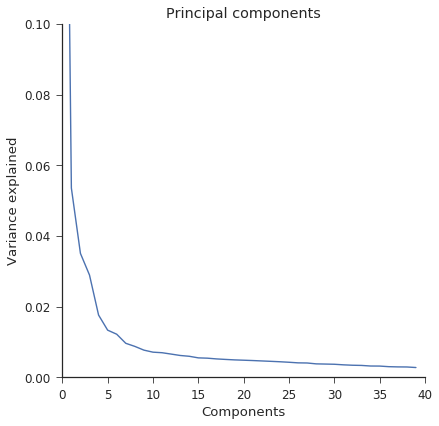

In [15]:
fig, ax = scanalysis.plots.plot.plot_pca_variance_explained_v1(data, n_components=40, random=True)

Results shown below for plot_pca_variance_explained_v2, which is MAGIC's version of the function.

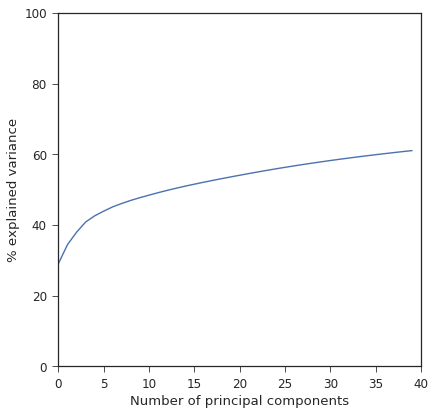

In [16]:
fig, ax = scanalysis.plots.plot.plot_pca_variance_explained_v2(data, n_components=40, random=True)

<a id="tsnevisual"></a>
### tSNE visualization

Wishbone uses [tSNE](#tsne) for visualization and tSNE can be run using the run_tsne function which takes the number of principal components as the parameter. From the above plot, 5 seems an appropriate number of components to use.

tSNE results can be visualized by the plot_tsne and plot_tsne_by_cell_sizes functions. The plot_tsne_by_cell_sizes function colors the cells by their molecule counts before normalization.

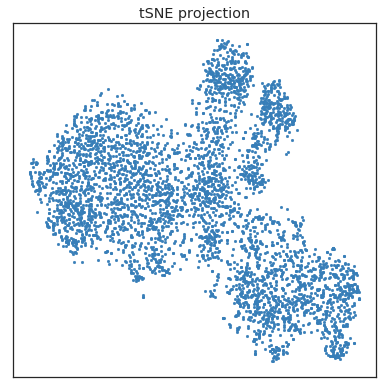

In [17]:
fig, ax = scanalysis.plots.plot.plot_tsne(d1)

(<matplotlib.figure.Figure at 0x11c4be208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c4c5048>)

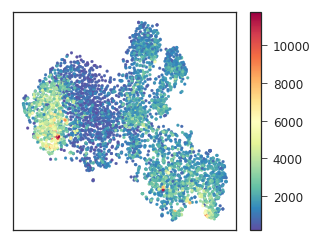

In [18]:
fig = plt.figure(figsize=[5, 4])
scanalysis.plots.plot.plot_tsne_by_cell_sizes(df, d1, fig = fig)

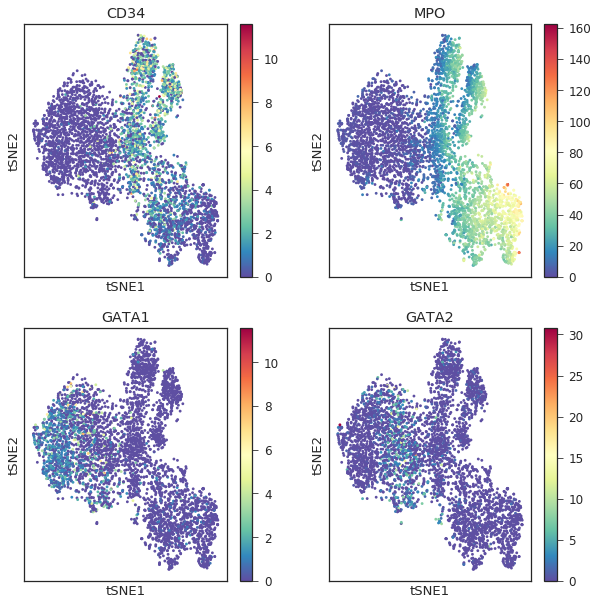

In [19]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data, d1, genes = ['CD34', 'GATA2', 'GATA1', 'MPO'])

<a id="dmvisual"></a>
### Diffusion map visualization

*Note: Please run [diffusion maps](#dmap) and [tSNE](#tsne) before plotting diffusion components (via plot_diffusion_components function).*

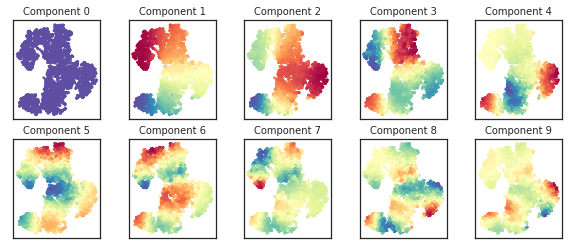

In [20]:
fig, ax = scanalysis.plots.plot.plot_diffusion_components(d, tempEigvec, tempEigval)

The run_diffusion_map_correlations function is designed to work for single cell RNA-seq (not mass-cyt).
Please run diffusion maps using run_diffusion_map before determining correlations.

Note: the component 0 is the trivial component and does not encode any information of the data.

In [21]:
dmap_corr = scanalysis.plots.plot.run_diffusion_map_correlations(data, tempEigvec)

After determining the diffusion map correlations, we can plot the gene component correlations (via plot_gene_component_correlations function).

(<matplotlib.figure.Figure at 0x11b649828>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c98dac8>)

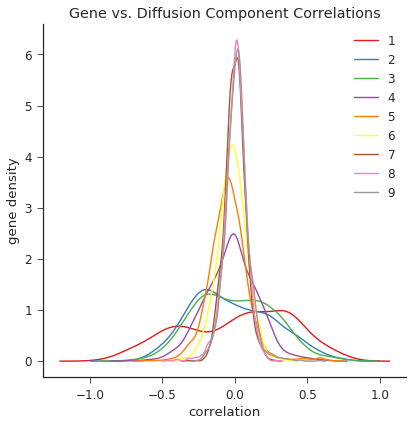

In [22]:
scanalysis.plots.plot.plot_gene_component_correlations(dmap_corr)

<a id="gsea"></a>
## Gene Set Enrichment Analysis (GSEA)
For more info on the original software, see [GSEA](http://software.broadinstitute.org/gsea/index.jsp)

The enrichments can be determined using the run_gsea function. This function needs the prefix for generating GSEA reports and a gmt file representing the different gene sets. The following invocation of the function shows the supported set of gmt files.

*Note: Please make sure to run run_diffusion_map_correlations() before running GSEA to annotate those components.*

Note: The gmt files package with Wishbone/SCAnalysis assume all the gene names to be upper case. This can be ensured using the following code to convert them to upper case.

In [ ]:
data.columns = data.columns.str.upper()

### Note: 
this was working perfectly fine before, but since I switched my computer, there is a PermissionError?

In [ ]:
scanalysis.tools.wb.gsea.run_gsea(dmap_corr, output_stem= os.path.expanduser('~/.scanalysis/tools/gsea/mouse_marrow'))

Since this is data from mouse, gmt_file parameter can be set to (mouse, gofat.bp.v1.0.gmt.txt)

In [ ]:
reports = scanalysis.tools.wb.gsea.run_gsea(dmap_corr, output_stem= os.path.expanduser('~/.scanalysis/gsea/mouse_marrow'), 
                          gmt_file=('mouse', 'gofat.bp.v1.0.gmt.txt'))

The detailed reports can be found at ~/.wishbone/gsea/

In [ ]:
!open ~/.scanalysis/gsea/

run_gsea function also returns the top enrichment gene sets along each component. GSEA determines enrichments that are either positively or negatively correlated with the gene component correlations. In this dataset, components 1 and 2 show relevant enrichments and are used for running Wishbone/SCAnalysis. Please see Selection of diffusion components for single cell RNA-seq section of the Supplementary Methods for more details.

In [ ]:
# Component 1 enrichments
reports[1]['neg']

In [ ]:
# Component 2 enrichments
reports[2]['pos']

<a id="wishbone"></a>
## Running Wishbone

For a visual representation of results, see [Plotting Wishbone Results](#wbplot)

Wishbone can be run by specifying the start cell and number of waypoints to be used. The start cell for this dataset was chosen based on high expression of CD34. (for each dataset, there is a corresponding start cell particular to that dataset)

*Note: Keep in mind that Wishbone requires data that has been run through [normalization](#norm), [PCA](#pca), and [diffusion maps](#dmap).*

Here, we will consider only 2 components.(?)

In [23]:
wb = scanalysis.tools.wb.wishbone.run_wishbone(tempEigvec.iloc[:,[1,2]], 'W30258', k=15, l=15, num_waypoints =250, branch=True)

Building lNN graph...
lNN computed in : 0.02 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
..........................................................................................................................................................................................................................................................
Time for determining distances and perspectives: 56.49 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  0.9987
Iteration: 3
Correlation with previous iteration:  0.9995
Iteration: 4
Correlation with previous iteration:  0.9998
Iteration: 5
Correlation with previous iteration:  0.9999
Iteration: 6
Correlation with previous iteration:  0.9999
5 realignment iterations


<a id="wbplot"></a>
## Plotting Wishbone Results

Use the WBResults class object returned from the run_wishbone function to plot various graphs.

<a id="wb_on_tsne"></a>
#### Plot Wishbone on tSNE maps
Wishbone trajectory and branch results can be visualized on tSNE maps using the plot_wishbone_on_tsne function.

*Note: Please make sure to run [Wishbone](#wishbone) before attempting to plot Wishbone results.*

Please make sure that the tSNE data entered corresponds to the Wishbone object you've entered.
        If yes, press enter to continue.
        If not, Ctrl-C to exit and retry with correct parameters.


(<matplotlib.figure.Figure at 0x11cadbda0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c45eda0>)

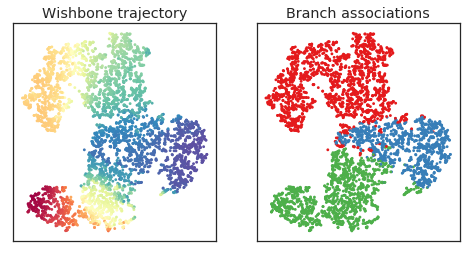

In [24]:
wb.plot_wishbone_on_tsne(d)

<a id="plot_marker_traj"></a>
#### Plot Marker Trajectory
Gene expression trends along the Wishbone trajectory can be visualized using the plot_marker_trajectory function. This function also returns the smoothed trends along with the matplotlib fig, ax handler objects.

Note: Variance calculation is currently not supported for single-cell RNA-seq (sc-seq)

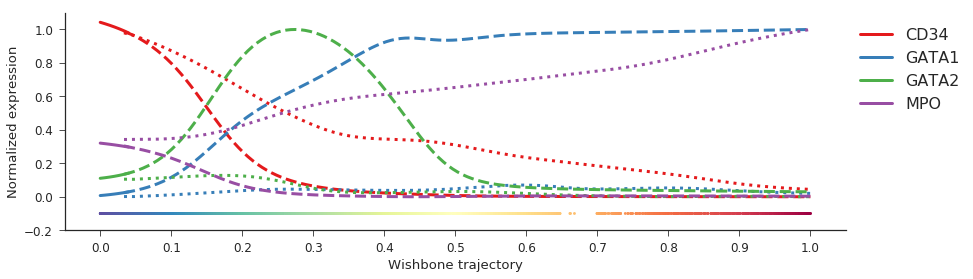

In [25]:
vals, fig, ax = wb.plot_marker_trajectory(data, ['CD34', 'GATA1', 'GATA2', 'MPO']);

<a id="plot_marker_hmap"></a>
#### Plot Marker Heatmap
The marker trends can be visualized as heatmaps in a given trajectory range using the following functions:

(<matplotlib.figure.Figure at 0x11c4219b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11e117668>)

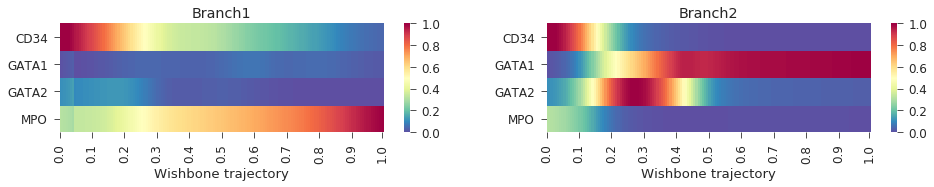

In [26]:
wb.plot_marker_heatmap(vals)

(<matplotlib.figure.Figure at 0x11db14588>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1284408d0>)

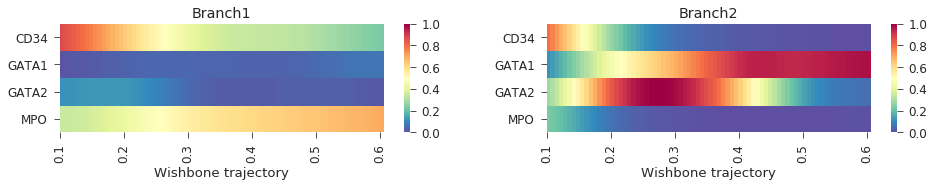

In [27]:
wb.plot_marker_heatmap(vals, trajectory_range=[0.1, 0.6])

<a id="plot_derivs"></a>
#### Plot Derivatives
The change in marker trends along the trajectory or derivatives can be visualized using these functions:

(<matplotlib.figure.Figure at 0x11c935208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11d7fc5f8>)

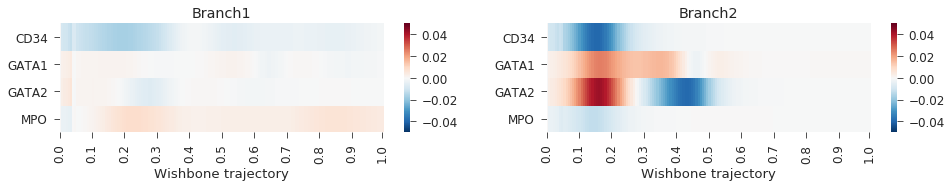

In [28]:
wb.plot_derivatives(vals)

(<matplotlib.figure.Figure at 0x11ba9ac88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11bf64cf8>)

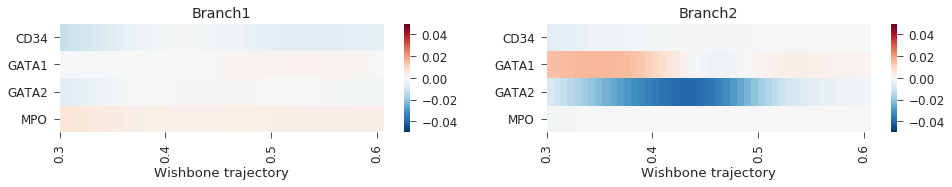

In [29]:
wb.plot_derivatives(vals, trajectory_range=[0.3, 0.6])

<a id="magic"></a>
## Running MAGIC

For a visual representation of MAGIC results, see [Plotting MAGIC Results](#mgplot)

MAGIC can be run with the run_magic function.

*Note: Data should be [filtered](#filter) and [normalized](#norm) before running MAGIC. Running PCA is not necessary, since the run_magic function automatically performs PCA.*

In [30]:
new_data = scanalysis.tools.magic.run_magic(data)

Doing PCA
Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_
Using pca_projections
Computing distances
Autotuning distances
Computing kernel
MAGIC: L_t = L^t
MAGIC: data_new = L_t * data


#### Let's try MAGIC with the data set used in the original MAGIC [notebook] as well.(http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [31]:
m_data = scanalysis.io.loadsave.load("~/sdata_nn_TGFb_day_8_10.csv")

Successfully loaded /Users/hjin/sdata_nn_TGFb_day_8_10.csv as a pd.DataFrame object


We have to filter the data, but we won't do it here because it's not necessary.

In [ ]:
# Minimum molecules/cell value
CELL_MIN = 0

# Maximum molecules/cell values
CELL_MAX = 1000000

# Minimum number of nonzero cells/gene 
# (None if no filtering desired)
GENE_NONZERO = None

# Minimum number of molecules/gene
# (None if no filtering desired)
GENE_MOLECULES = None

m_data = scanalysis.io.preprocess.filter_scseq_data(m_data, filter_cell_min=CELL_MIN, filter_cell_max=CELL_MAX, 
                         filter_gene_nonzero=GENE_NONZERO, filter_gene_mols=GENE_MOLECULES)
## ^but this takes forever...
### also Pooja doesn't actually filter the data in the example notebook 
## (there are just dummy parameters as an example of how to call the filtering function), so you should still be able to tes

Let's normalize the data though.

In [33]:
m_data = scanalysis.io.preprocess.normalize_scseq_data(m_data)

Successfully normalized data


Then, let's apply the run_magic function on m_data.

In [34]:
new_m_data = scanalysis.tools.magic.run_magic(m_data)

Doing PCA
Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_
Using pca_projections
Computing distances
Autotuning distances
Computing kernel
MAGIC: L_t = L^t
MAGIC: data_new = L_t * data


<a id="mgplot"></a>
## Plotting MAGIC Results

*Note: Please make sure to run [MAGIC](#magic) on normalized data before attempting to plot various MAGIC results.*

### Gene-gene scatter plots

#### 2D scatter plot before MAGIC:

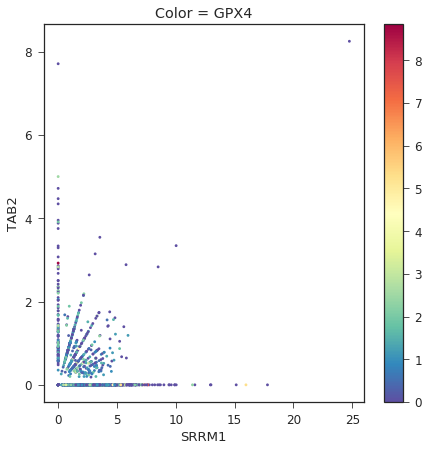

In [35]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(data, ['SRRM1', 'TAB2'], color = 'GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

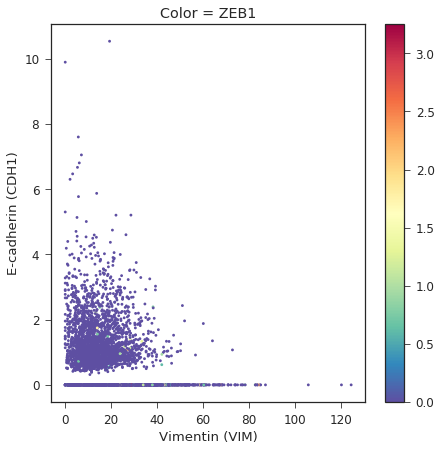

In [36]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(m_data, ['VIM', 'CDH1'], color='ZEB1')
ax.set_xlabel('Vimentin (VIM)')
ax.set_ylabel('E-cadherin (CDH1)')

#### 2D scatter plot after MAGIC:

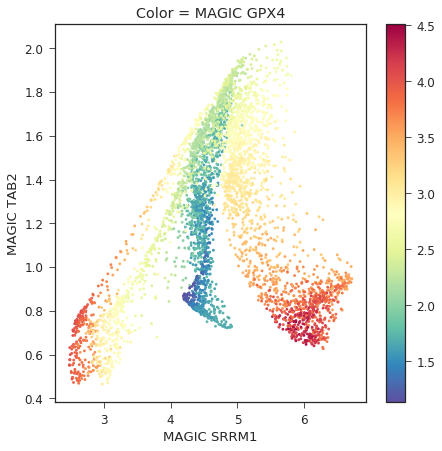

In [37]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_data, ['MAGIC SRRM1', 'MAGIC TAB2'], color = 'MAGIC GPX4')
ax.set_xlabel('MAGIC SRRM1')
ax.set_ylabel('MAGIC TAB2')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

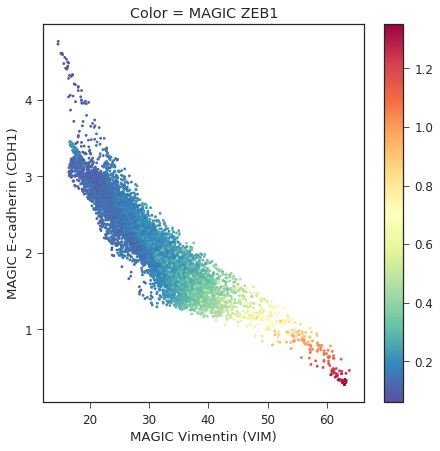

In [38]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_m_data, ['MAGIC VIM', 'MAGIC CDH1'], color ='MAGIC ZEB1')
ax.set_xlabel('MAGIC Vimentin (VIM)')
ax.set_ylabel('MAGIC E-cadherin (CDH1)')

#### 3D scatter plot before MAGIC:

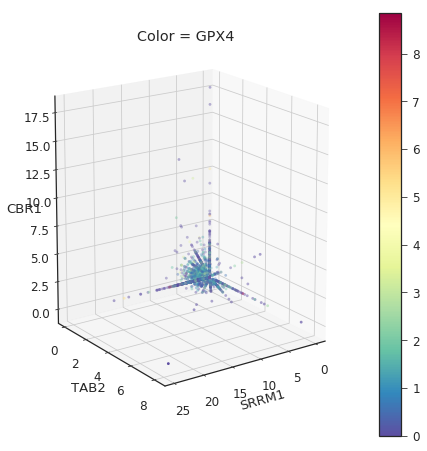

In [39]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(data, ['SRRM1', 'TAB2', 'CBR1'], color='GPX4')
ax.set_xlabel('SRRM1')
ax.set_ylabel('TAB2')
ax.set_zlabel('CBR1')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

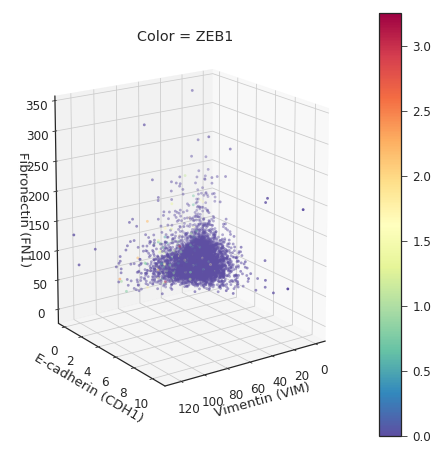

In [40]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(m_data, ['VIM', 'CDH1', 'FN1'], color='ZEB1')
ax.set_xlabel('Vimentin (VIM)')
ax.set_ylabel('E-cadherin (CDH1)')
ax.set_zlabel('Fibronectin (FN1)')

#### 3D scatter plot after MAGIC:

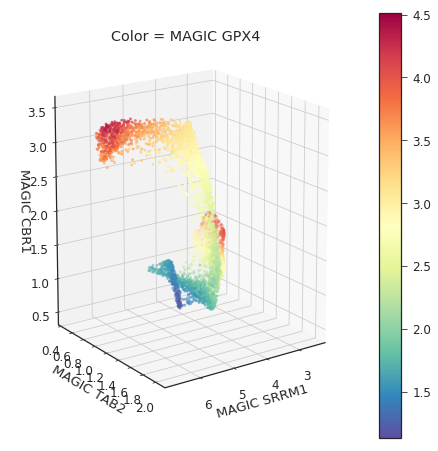

In [41]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_data, ['MAGIC SRRM1', 'MAGIC TAB2', 'MAGIC CBR1'], color='MAGIC GPX4')
ax.set_xlabel('MAGIC SRRM1')
ax.set_ylabel('MAGIC TAB2')
ax.set_zlabel('MAGIC CBR1')

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

(35, 150)

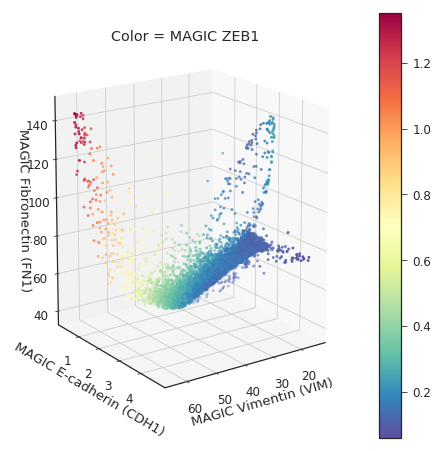

In [42]:
fig, ax = scanalysis.plots.plot.scatter_gene_expression(new_m_data, ['MAGIC VIM', 'MAGIC CDH1', 'MAGIC FN1'], color='MAGIC ZEB1')
ax.set_xlabel('MAGIC Vimentin (VIM)')
ax.set_ylabel('MAGIC E-cadherin (CDH1)')
ax.set_zlabel('MAGIC Fibronectin (FN1)')
ax.set_zlim(35, 150)

<a id="magicpcaplots"></a>
### PCA scatter plots

#### PC2 vs PC3 colored by CDH1, VIM, FN1 and ZEB1 (before MAGIC):

### potential PROBLEMS:
* there's a problem with PCA scatter plot after MAGIC --> does not produce the correct results, need to look into it further
* also tSNE scatter plots don't look the exact same as MAGIC notebook's??
* didn't quite figure FigureGrid, ie how to add scatterplot info to the generated layout (can you?) --> for now, just focus on the original way to generate the figures (in magic notebook)


First, however, we should set up our data. Add to temp the column names of the various Principal Components.

In [43]:
temp.columns = ['PC1','PC2','PC3','PC4','PC5']

Then, combine data and temp into one combined dataset, which is assigned to variable x below.

In [44]:
x = pd.concat([data, temp], axis=1)

Finally, let's plot.

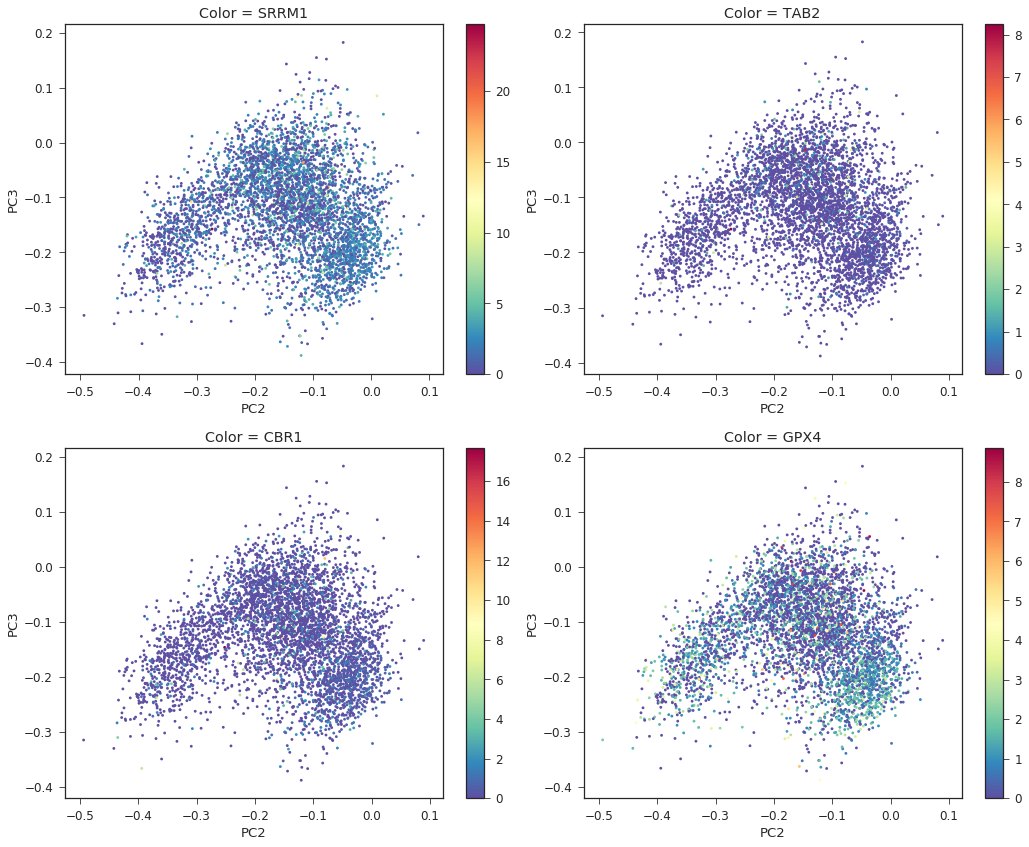

In [45]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=[15, 12])
genes = ['SRRM1', 'TAB2', 'CBR1', 'GPX4']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scanalysis.plots.plot.scatter_gene_expression(x, genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [46]:
pca1, pca2 = scanalysis.utils.pca.run_pca(m_data, 5)

pca1.columns = ['PC1','PC2','PC3','PC4','PC5']

x1 = pd.concat([m_data, pca1], axis=1)

Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_


In [47]:
x1

5_8S_rRNA  A1BG  A1BG-AS1  A2M  A2M-AS1  A2ML1  A2ML1-AS1  A4GALT  \
5S_rRNA                                                                      
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
...            ...   ...       ...  ...      ...    ...        ...     ...   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       0.0  0.0      0.0    0.0        0.0     0.0   
0              0.0   0.0       

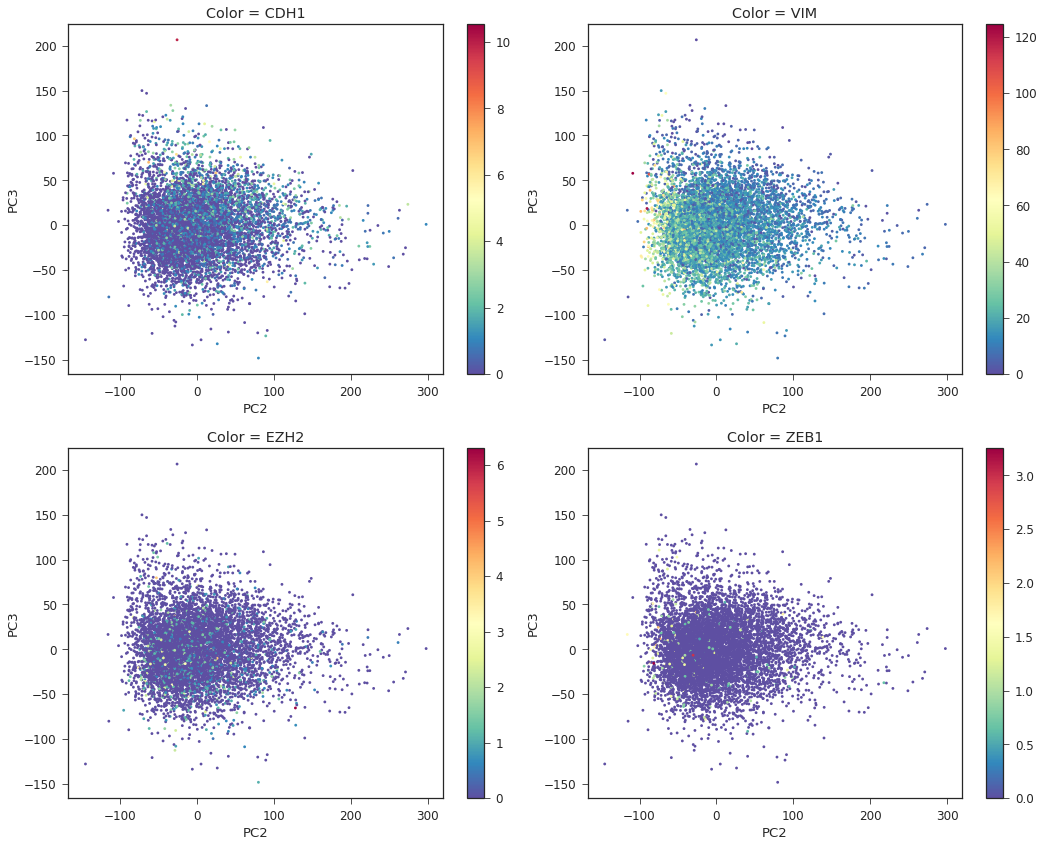

In [48]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=[15, 12])
genes = ['CDH1', 'VIM', 'EZH2', 'ZEB1']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scanalysis.plots.plot.scatter_gene_expression(x1, genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

#### PC2 vs PC3 colored by CDH1, VIM, FN1 and ZEB1 (after MAGIC):

In [49]:
x2 = pd.concat([new_data, temp], axis=1)
x2

MAGIC SRRM1  MAGIC ZFP106  MAGIC TAB2  MAGIC TXNRD2  MAGIC GRINL1A  \
W29956     4.801985      3.530075    1.648740      0.992195       4.529602   
W30018     4.338214      3.208445    1.481532      0.809141       4.483518   
W30161     4.858542      3.670900    1.280465      1.242986       3.883307   
W30203     4.107018      2.877348    1.328850      0.814980       4.800919   
W30258     3.165111      2.172156    0.804392      0.829582       5.469828   
W30296     4.125229      3.435906    1.162895      0.794324       3.900441   
W30301     2.855687      1.905425    0.584090      0.714719       5.306994   
W30306     3.055897      2.102612    0.746126      0.763285       5.412404   
W31106     4.385124      3.986690    1.262665      0.771134       3.514035   
W31108     4.729937      4.561610    1.440850      0.869150       3.547243   
W31110     4.493501      4.078750    1.382644      0.909863       3.659241   
W31117     4.451791      3.600302    1.607837      0.866171       4.081092   
W31118     4.660136      4.285859    1.488413      0.927503       3.680031   
W31119     4.849783      3.621344    1.808124      0.868469       4.529530   
W31129     5.114409      3.852391    1.763432      1.083224       4.413077   
W31130     4.418688      3.928348    1.208538      0.725245       3.493270   
W31131     4.403229      4.057522    1.265929      0.768419       3.521924   
W31141     4.566921      3.393187    1.631594      0.825730       4.473364   
W31145     4.404794      3.920018    1.141819      0.695895       3.450630   
W31148     4.481889      4.065547    1.366800      0.844638       3.556177   
W31152     4.511299      4.029540    1.429865      0.892000       3.608188   
W31157     4.761755      3.392871    1.703737      1.002217       4.571122   
W31158     4.421860      4.082618    1.311472      0.809276       3.546770   
W31160     4.899961      4.272915    1.716637      0.922476       3.928222   
W31164     4.392396      3.991564    1.246239      0.747636       3.485607   
W31166     4.538677      3.804297    1.523499      0.842478       3.903309   
W31168     4.811920      4.332877    1.710362      0.955700       3.716028   
W31169     4.783216      4.241201    1.638034      0.951855       3.790100   
W31170     4.770470      4.575934    1.526887      0.919539       3.564452   
W31174     4.904189      3.503653    1.824600      0.980638       4.569418   
...             ...           ...         ...           ...            ...   
W75961     4.934462      3.733032    1.442882      1.278638       3.963676   
W75964     4.229072      3.359049    0.949617      0.780777       3.887025   
W75965     6.258612      3.963620    0.689623      2.582849       4.486363   
W75966     4.250509      3.132517    0.847259      0.833025       2.717521   
W75968     4.495009      3.901594    1.299712      0.865436       3.677418   
W75969     5.056263      3.889850    1.439033      1.269507       3.991414   
W75974     4.462342      3.614040    0.813314      0.716991       3.037232   
W75977     4.495742      3.691720    0.989343      0.701837       3.365968   
W75993     6.296532      3.886278    0.678496      2.765843       4.271711   
W75996     3.021015      2.056308    0.749283      0.778685       5.491075   
W76001     4.708018      3.389442    1.638670      0.976358       4.650206   
W76042     4.471151      3.714314    1.124525      0.805755       3.677559   
W76054     4.316517      3.789437    1.462200      0.927097       3.721749   
W76062     5.146877      3.890124    1.156050      1.402305       3.995903   
W76063     4.523411      3.669544    1.035487      0.737257       3.484359   
W76070     6.164820      4.283816    0.771836      2.404642       4.048335   
W76071     2.804352      1.778130    0.750726      0.754286       5.448479   
W76089     3.424103      2.401314    0.735598      0.748589       4.847105   
W76149     6.094729      3.586827    0.678870      2.699334       3.932871   
W76150     3.617510      2.599

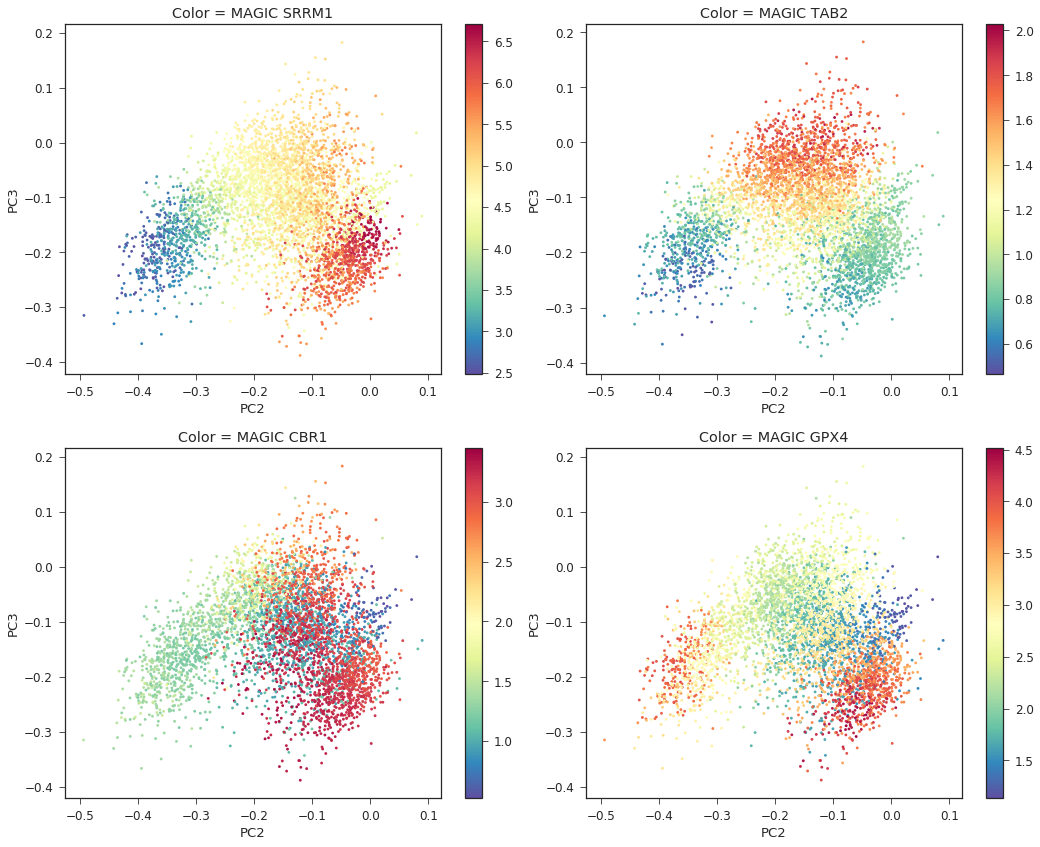

In [50]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=[15, 12])
genes = ['MAGIC SRRM1', 'MAGIC TAB2', 'MAGIC CBR1', 'MAGIC GPX4']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scanalysis.plots.plot.scatter_gene_expression(x2, genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [51]:
x3 = pd.concat([new_m_data, pca1], axis=1)

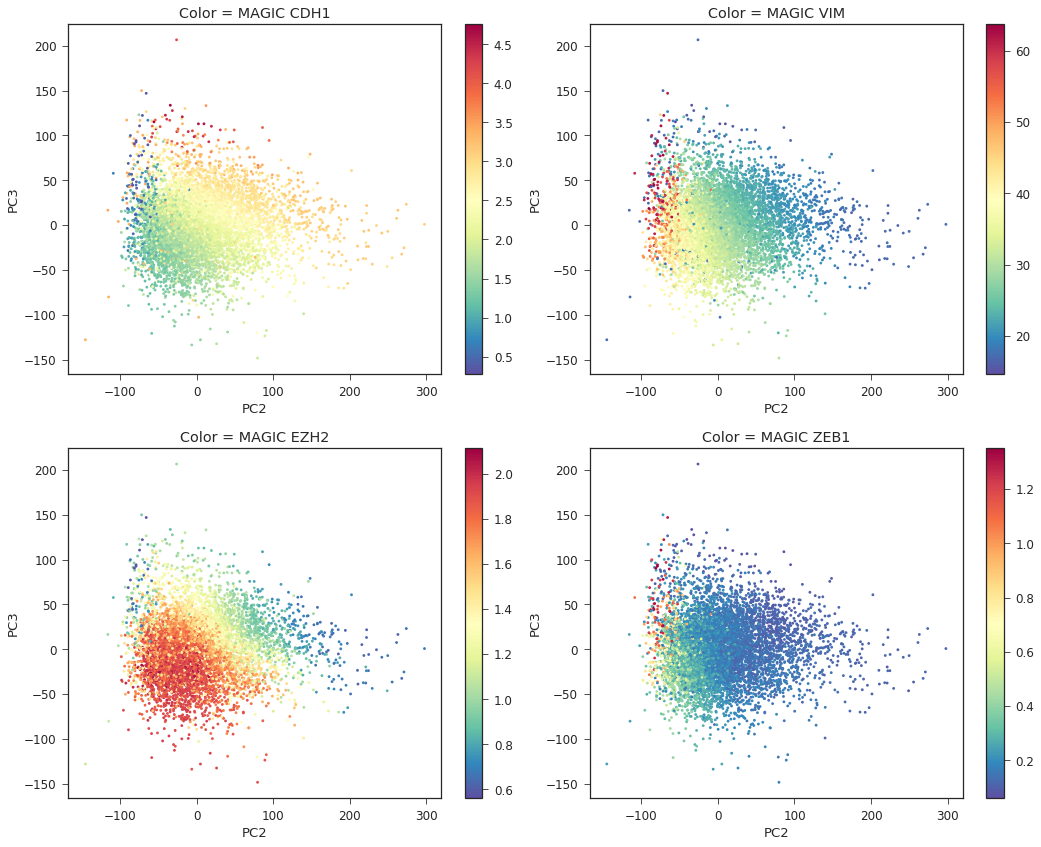

In [52]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=[15, 12])
genes = ['MAGIC CDH1', 'MAGIC VIM', 'MAGIC EZH2', 'MAGIC ZEB1']
for i in range(len(genes)):
    ax = fig.add_subplot(gs[i//2, i%2])
    scanalysis.plots.plot.scatter_gene_expression(x3, genes=['PC2', 'PC3'], color=genes[i], fig=fig, ax=ax)

<a id="magictsneplots"></a>
### tSNE scatter plots

#### tSNE maps colored by CDH1, VIM, FN1, and ZEB1 (before MAGIC):

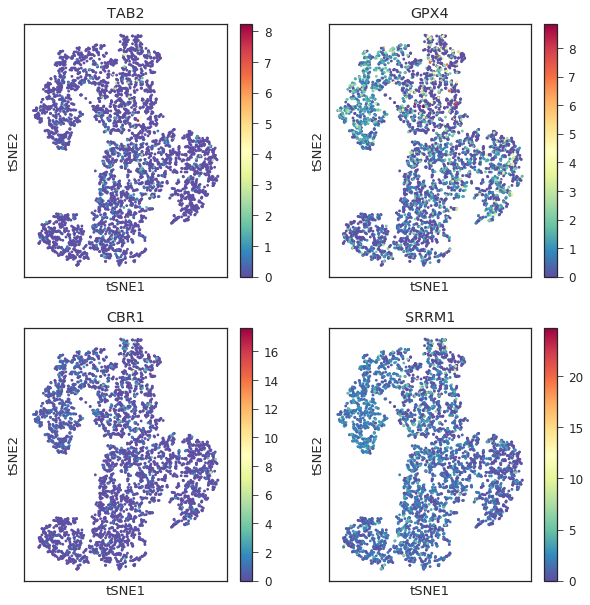

In [53]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data=data, tsne=d, genes=['SRRM1', 'TAB2', 'CBR1', 'GPX4'])

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

In [54]:
t1 = scanalysis.utils.tsne.TSNE()
d1 = t1.fit_transform(pca1)

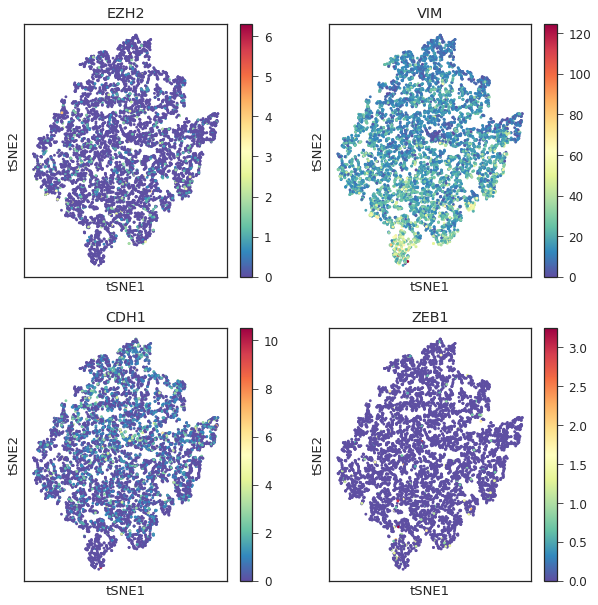

In [55]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data=m_data, tsne=d1, genes=['CDH1', 'VIM', 'EZH2', 'ZEB1'])

#### tSNE maps colored by CDH1, VIM, FN1, and ZEB1 (after MAGIC):

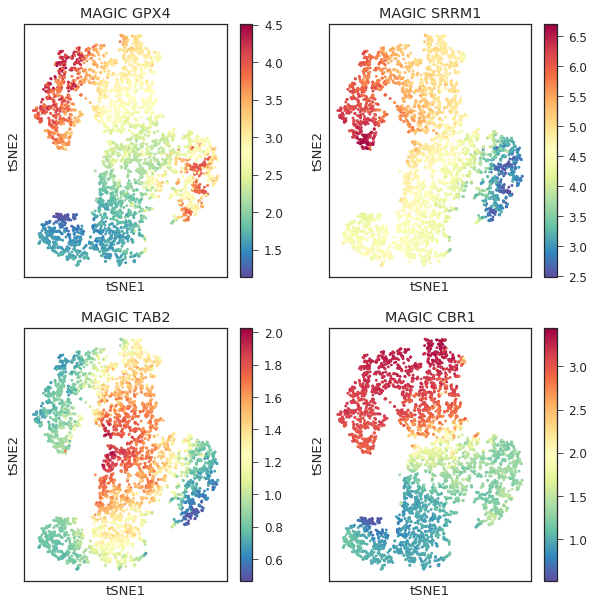

In [56]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data=new_data, tsne=d, genes=['MAGIC SRRM1', 'MAGIC TAB2', 'MAGIC CBR1', 'MAGIC GPX4'])

The second plot below is for the data set used in the original MAGIC [notebook](http://nbviewer.jupyter.org/github/pkathail/magic/blob/develop/notebooks/Magic_single_cell_RNAseq.ipynb).

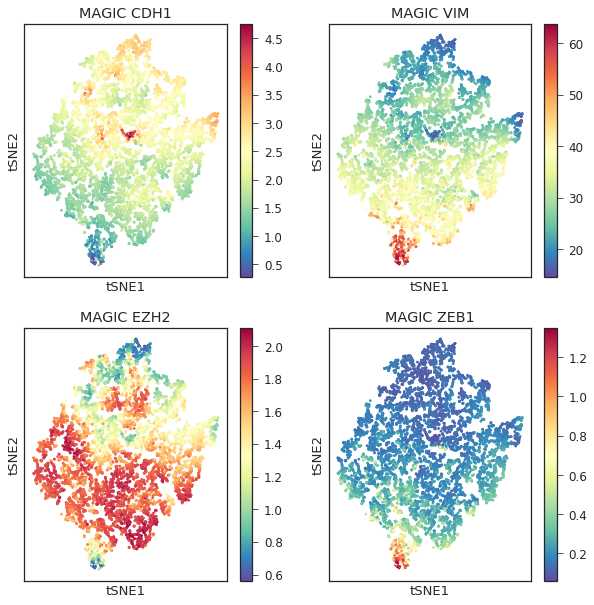

In [57]:
fig, ax = scanalysis.plots.plot.plot_gene_expression(data=new_m_data, tsne=d1, genes=['MAGIC CDH1', 'MAGIC VIM', 'MAGIC EZH2', 'MAGIC ZEB1'])

<a id="savefig"></a>
## Saving figures
You can save a figure as a png file using "savefig" as shown below.

In [58]:
scanalysis.plots.plot.savefig(fig, 'h')

<a id="palantir"></a>
## Running Palantir

First, load the pickle file with the data. The data is normalized and log transformed. 

In [59]:
import scanalysis

In [60]:
mb_data = scanalysis.io.loadsave.load("~/mb_data.p")

Successfully loaded /Users/hjin/mb_data.p as a <class 'pandas.core.frame.DataFrame'> object


In [61]:
import pandas as pd
import numpy as np

We need the data to be in cells x genes format (index x columns), so in this case we will switch the rows and columns to achieve this.

In [62]:
mb_data = pd.DataFrame.transpose(mb_data)

In [63]:
mb_data

KCTD15     STT3B      NAT6      FHL2    SP140L  \
Run4_120703408880541 -3.321928 -3.321928 -3.321928  0.171306 -3.321928   
Run4_120703409056541 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120703409580963 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120703423990708 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120703424252854 -3.321928 -0.365265 -3.321928 -3.321928 -3.321928   
Run4_120703436876077 -3.321928 -3.321928  0.363786  0.363786  0.363786   
Run4_120703455025387 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120726911638237 -3.321928  0.918170 -3.321928 -3.321928 -3.321928   
Run4_120726912355038 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120726924974443 -3.321928 -0.910988 -3.321928 -3.321928 -3.321928   
Run4_120726924978030 -3.321928 -0.369327 -3.321928 -3.321928 -3.321928   
Run4_120726943295348 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120726943845302 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120772961130853 -3.321928 -3.321928 -3.321928  0.282395 -3.321928   
Run4_120786758780660 -3.321928 -3.321928  0.047722 -3.321928 -3.321928   
Run4_120786786086116 -3.321928  0.245224  0.245224 -3.321928  0.245224   
Run4_120786804205803 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_120786804401973 -3.321928 -3.321928 -0.212571 -3.321928 -3.321928   
Run4_120797898099934 -3.321928 -0.736818 -3.321928 -3.321928 -3.321928   
Run4_120797925428019 -3.321928  0.810766 -0.109248 -3.321928 -3.321928   
Run4_120797944278244 -3.321928 -3.321928 -3.321928  0.319141 -3.321928   
Run4_120797944309486 -3.321928 -0.597133 -3.321928 -3.321928 -3.321928   
Run4_120797944462237 -3.321928  1.583616 -3.321928 -3.321928 -3.321928   
Run4_120797944538971 -3.321928 -3.321928  0.106350  1.037736 -3.321928   
Run4_120797945084765 -3.321928  1.128506 -3.321928 -3.321928 -3.321928   
Run4_120864497952619 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_121202296155437 -0.803194 -0.803194 -0.803194  0.065101 -0.803194   
Run4_121202296712412 -3.321928  0.731223 -3.321928 -3.321928 -3.321928   
Run4_121202296875939 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run4_121202311609131 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
...                        ...       ...       ...       ...       ...   
Run5_240634599983342 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_240634599986987  0.702973  0.702973 -3.321928 -3.321928 -3.321928   
Run5_240634613909861 -3.321928  0.388657 -3.321928 -0.505150 -3.321928   
Run5_240634614373595 -3.321928 -0.022172 -0.022172 -3.321928 -3.321928   
Run5_240634614729955 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_240634626784550 -3.321928 -3.321928 -3.321928  1.289575 -3.321928   
Run5_240634645855022 -3.321928 -0.151090 -3.321928 -3.321928 -0.151090   
Run5_240634646116662 -3.321928 -3.321928 -3.321928  0.543496 -3.321928   
Run5_241057653508843 -3.321928 -3.321928  0.102278 -3.321928 -3.321928   
Run5_241057653738918 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_241057654294885 -3.321928  0.719076  0.719076 -3.321928 -3.321928   
Run5_241057668712349 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_241057680972510 -3.321928 -3.321928  0.131881 -3.321928 -3.321928   
Run5_241057681259245 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_241057700113179 -3.321928  0.200470 -3.321928 -3.321928  0.200470   
Run5_241098858613659 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_241098858810213 -3.321928  0.910984 -0.014261 -3.321928 -3.321928   
Run5_241098873552118 -3.321928  0.099779 -3.321928 -3.321928 -3.321928   
Run5_241098885647774 -3.321928 -3.321928 -3.321928  1.098178 -3.321928   
Run5_241098904976174 -0.080268 -0.080268 -3.321928 -3.321928 -3.321928   
Run5_241098905205038 -3.321928 -3.321928 -3.321928  0.590031 -3.321928   
Run5_241106375007076 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928   
Run5_241106389756316 -3.3219

In [64]:
DMEigVals = scanalysis.io.loadsave.load("~/palantir/dm_eig_vals.csv")

Successfully loaded /Users/hjin/palantir/dm_eig_vals.csv as a pd.DataFrame object


In [65]:
DMEigs = scanalysis.io.loadsave.load("~/palantir/dm_eigs.csv")

Successfully loaded /Users/hjin/palantir/dm_eigs.csv as a pd.DataFrame object


Note: the run_multibranch function takes ~10 minutes.

Use the following parameters when running run_multibranch for this particular data set:
* start_cell: Run5_126835192163230
* num_waypoints: 300
* flock = 0

In [66]:
der = scanalysis.tools.pr.palantir.run_multibranch(data_ = mb_data, DMEigs = DMEigs, DMEigVals = DMEigVals, dm_eigs = [1,2,3], start_cell="Run5_126835192163230", num_waypoints = 300, flock = 0)


Sampling and flocking waypoints...
Time for determining waypoints: 0.0025870164235432943 minutes
Shortest path distances...
Time for shortest paths: 6.396327050526937 minutes
Determining perspectives, trajectory...
Correlation at iteration 1: 1.0000
Determining terminal states...
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


/usr/local/lib/python3.6/site-packages/scanalysis/tools/pr/palantir.py:162: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(pairwise_distances(data.loc[cells,:]))
/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


#### Compare trajectory results with the trajectory.csv file using a scatter plot...

In [67]:
atrajectory = scanalysis.io.loadsave.load("~/palantir/trajectory.csv")

Successfully loaded /Users/hjin/palantir/trajectory.csv as a pd.DataFrame object


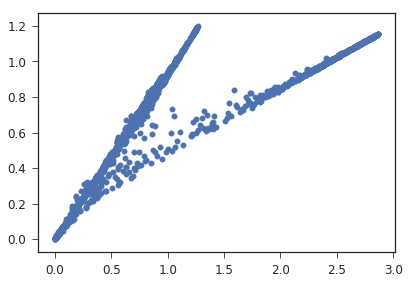

In [68]:
plt.scatter(der.trajectory, atrajectory)

<a id="prplot"></a>
## Plotting Palantir Results

Here, we will try the first five genes in the data matrix. You shouldn't plot all the markers because that will kill your computer.  

In [70]:
mb_data_f5 = mb_data.iloc[:,0:5]

In [71]:
mb_data_f5

KCTD15     STT3B      NAT6      FHL2    SP140L
Run4_120703408880541 -3.321928 -3.321928 -3.321928  0.171306 -3.321928
Run4_120703409056541 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120703409580963 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120703423990708 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120703424252854 -3.321928 -0.365265 -3.321928 -3.321928 -3.321928
Run4_120703436876077 -3.321928 -3.321928  0.363786  0.363786  0.363786
Run4_120703455025387 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120726911638237 -3.321928  0.918170 -3.321928 -3.321928 -3.321928
Run4_120726912355038 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120726924974443 -3.321928 -0.910988 -3.321928 -3.321928 -3.321928
Run4_120726924978030 -3.321928 -0.369327 -3.321928 -3.321928 -3.321928
Run4_120726943295348 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120726943845302 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120772961130853 -3.321928 -3.321928 -3.321928  0.282395 -3.321928
Run4_120786758780660 -3.321928 -3.321928  0.047722 -3.321928 -3.321928
Run4_120786786086116 -3.321928  0.245224  0.245224 -3.321928  0.245224
Run4_120786804205803 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120786804401973 -3.321928 -3.321928 -0.212571 -3.321928 -3.321928
Run4_120797898099934 -3.321928 -0.736818 -3.321928 -3.321928 -3.321928
Run4_120797925428019 -3.321928  0.810766 -0.109248 -3.321928 -3.321928
Run4_120797944278244 -3.321928 -3.321928 -3.321928  0.319141 -3.321928
Run4_120797944309486 -3.321928 -0.597133 -3.321928 -3.321928 -3.321928
Run4_120797944462237 -3.321928  1.583616 -3.321928 -3.321928 -3.321928
Run4_120797944538971 -3.321928 -3.321928  0.106350  1.037736 -3.321928
Run4_120797945084765 -3.321928  1.128506 -3.321928 -3.321928 -3.321928
Run4_120864497952619 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_121202296155437 -0.803194 -0.803194 -0.803194  0.065101 -0.803194
Run4_121202296712412 -3.321928  0.731223 -3.321928 -3.321928 -3.321928
Run4_121202296875939 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run4_121202311609131 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
...                        ...       ...       ...       ...       ...
Run5_240634599983342 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_240634599986987  0.702973  0.702973 -3.321928 -3.321928 -3.321928
Run5_240634613909861 -3.321928  0.388657 -3.321928 -0.505150 -3.321928
Run5_240634614373595 -3.321928 -0.022172 -0.022172 -3.321928 -3.321928
Run5_240634614729955 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_240634626784550 -3.321928 -3.321928 -3.321928  1.289575 -3.321928
Run5_240634645855022 -3.321928 -0.151090 -3.321928 -3.321928 -0.151090
Run5_240634646116662 -3.321928 -3.321928 -3.321928  0.543496 -3.321928
Run5_241057653508843 -3.321928 -3.321928  0.102278 -3.321928 -3.321928
Run5_241057653738918 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241057654294885 -3.321928  0.719076  0.719076 -3.321928 -3.321928
Run5_241057668712349 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241057680972510 -3.321928 -3.321928  0.131881 -3.321928 -3.321928
Run5_241057681259245 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241057700113179 -3.321928  0.200470 -3.321928 -3.321928  0.200470
Run5_241098858613659 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241098858810213 -3.321928  0.910984 -0.014261 -3.321928 -3.321928
Run5_241098873552118 -3.321928  0.099779 -3.321928 -3.321928 -3.321928
Run5_241098885647774 -3.321928 -3.321928 -3.321928  1.098178 -3.321928
Run5_241098904976174 -0.080268 -0.080268 -3.321928 -3.321928 -3.321928
Run5_241098905205038 -3.321928 -3.321928 -3.321928  0.590031 -3.321928
Run5_241106375007076 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241106389756316 -3.321928  1.671793 -3.321928 -3.321928 -3.321928
Run5_241106389784372 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_241106401770805 -3.321928  1.560339 -3.3219

Run the plot_markers function to visualize results.

### PROBLEM: 
when compute_std parameter is set to True, results in ValueError, what seems to be happening is that the the program is trying to reshape the original array of 5 (which holds the trends) into array of dimensions 5x500, but it can't because there are only 5 elements in the original array. 500 is derived from the traj_bins instance variable, which was initialized according to the no_bins parameter. In reality, the trends array can only be reshaped into an array of 5x1 dimensions... so I was wondering, is the length of trends correct?

In [72]:
der.compute_marker_trends(mb_data_f5, der.branch_prob.columns, True, n_jobs=1)

Run4_235626713532342


ValueError: cannot reshape array of size 5 into shape (5,500)

It works when compute_std parameter is set to False, shown below:

In [73]:
der.compute_marker_trends(mb_data_f5, der.branch_prob.columns, False, n_jobs=1)

Run4_235626713532342
Time for processing Run4_235626713532342: 0.014844397703806559 minutes
Run5_161340154039083
Time for processing Run5_161340154039083: 0.006732730070749918 minutes
Run5_239477254471070
Time for processing Run5_239477254471070: 0.006731267770131429 minutes


OrderedDict([('Run4_235626713532342',
                      0.000000  0.002004  0.004008  0.006012  0.008016  0.010020  0.012024  \
              KCTD15 -3.225504 -3.225160 -3.224816 -3.224472 -3.224128 -3.223784 -3.223441   
              STT3B  -1.916802 -1.911549 -1.906297 -1.901044 -1.895792 -1.890542 -1.885294   
              NAT6   -3.045862 -3.041950 -3.038037 -3.034124 -3.030211 -3.026297 -3.022382   
              FHL2   -3.072209 -3.067231 -3.062253 -3.057275 -3.052297 -3.047319 -3.042342   
              SP140L -2.967481 -2.966764 -2.966046 -2.965328 -2.964611 -2.963893 -2.963175   
              
                      0.014028  0.016032  0.018036    ...     0.981964  0.983968  0.985972  \
              KCTD15 -3.223099 -3.222758 -3.222417    ...    -2.736523 -2.729153 -2.721772   
              STT3B  -1.880050 -1.874811 -1.869577    ...    -1.737771 -1.739521 -1.741268   
              NAT6   -3.018465 -3.014545 -3.010622    ...    -2.885506 -2.891393 -2.897279   
       

<a id="plot_markers"></a>
##  Plot markers

But let's plot the markers onto a graph- the function plot_markers will automatically call compute_marker_trends by itself, so *there is no need to explicitly call the function compute_markers_trends like we did above.*

Run4_235626713532342
Time for processing Run4_235626713532342: 0.01637901465098063 minutes
Run5_161340154039083
Time for processing Run5_161340154039083: 0.010799519220987956 minutes
Run5_239477254471070
Time for processing Run5_239477254471070: 0.01175938049952189 minutes


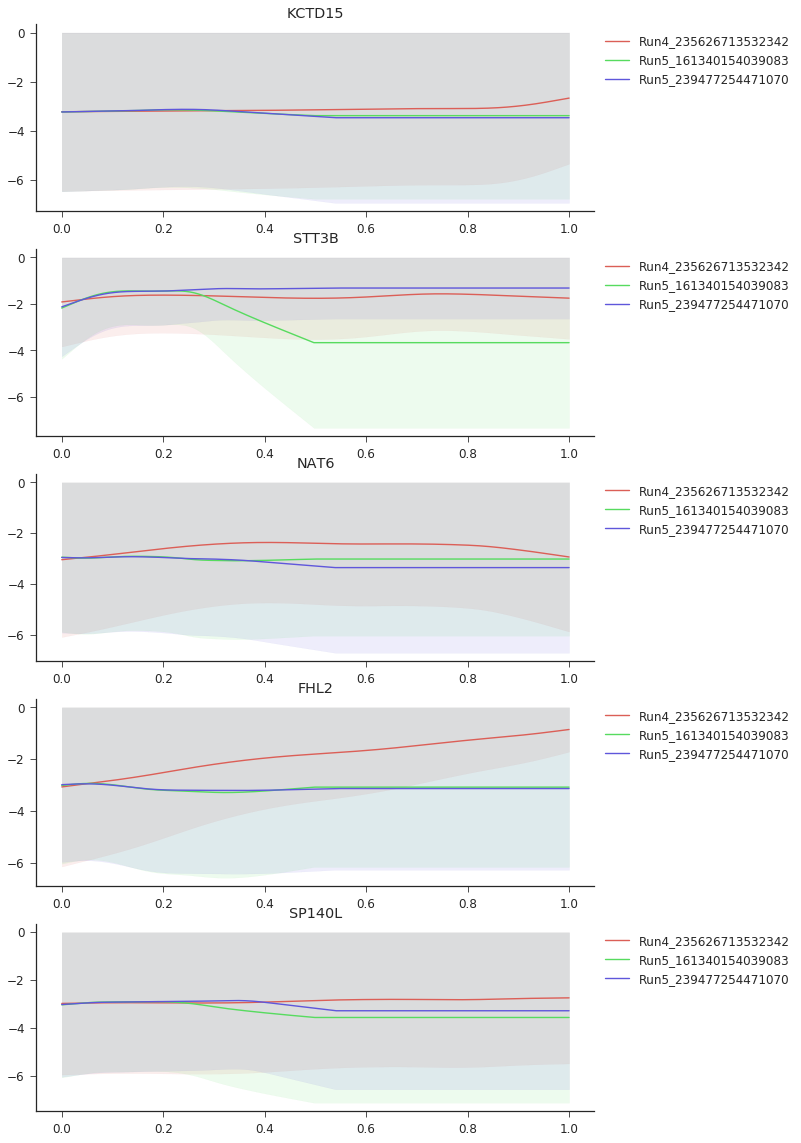

In [74]:
der.plot_markers(mb_data_f5, branches = der.branch_prob.columns)

<a id="pr_on_tsne"></a>
## Palantir on tSNE maps

Let's see the tSNE maps of this particular dataset.

In [76]:
m, n = scanalysis.utils.pca.run_pca(mb_data)

Successfully ran PCA, and returning:
pca_projections
pca.explained_variance_ratio_


In [77]:
t2 = scanalysis.utils.tsne.TSNE()
d2 = t2.fit_transform(m)

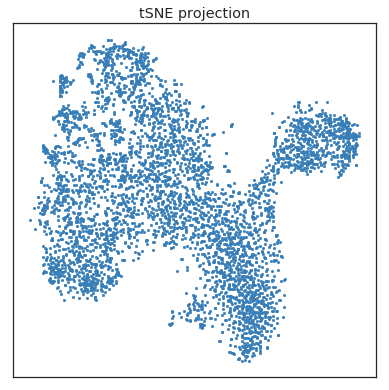

In [78]:
fig, ax = scanalysis.plots.plot.plot_tsne(d2)

(<matplotlib.figure.Figure at 0x11e3ba0b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11e3ba080>)

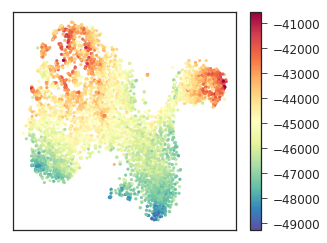

In [80]:
fig = plt.figure(figsize=[5, 4])
scanalysis.plots.plot.plot_tsne_by_cell_sizes(mb_data, d2, fig = fig)

Use the tSNE data provided by Manu.

In [82]:
tsne = scanalysis.io.loadsave.load('~/tsne.csv')

Successfully loaded /Users/hjin/tsne.csv as a pd.DataFrame object


Filter out and only include the tSNE data that corresponds to the original mb_data dataset. In other words, filter out to take only the cell names in the index of mb_data from tSNE data.

In [83]:
tsne1 = tsne.loc[mb_data.index]

In [85]:
tsne1

x          y
Run4_120703408880541  -9.938553  -3.918489
Run4_120703409056541 -29.987230   5.025842
Run4_120703409580963   8.778947 -21.146475
Run4_120703423990708   8.304699 -20.570558
Run4_120703424252854  34.838399  -8.290442
Run4_120703436876077 -21.483573  12.986087
Run4_120703455025387  16.528668  12.909906
Run4_120726911638237  22.247869   7.292149
Run4_120726912355038   7.143360   9.374328
Run4_120726924974443  10.166742   6.552430
Run4_120726924978030   5.630279  18.002874
Run4_120726943295348   9.359823 -21.175617
Run4_120726943845302  11.177851  -4.365635
Run4_120772961130853 -14.602084  11.574279
Run4_120786758780660  -9.246595  19.675193
Run4_120786786086116 -14.483479  17.721635
Run4_120786804205803  25.178340   5.149995
Run4_120786804401973   3.927354  14.469976
Run4_120797898099934  19.476349   3.277522
Run4_120797925428019  -1.694995  20.516168
Run4_120797944278244  -8.974321 -15.999008
Run4_120797944309486  -8.965051  -9.449672
Run4_120797944462237 -15.140176  18.118078
Run4_120797944538971 -11.394474   0.309655
Run4_120797945084765 -19.016624  17.388215
Run4_120864497952619  34.515769 -13.917341
Run4_121202296155437  -9.864364 -24.259759
Run4_121202296712412  36.173311  -9.565256
Run4_121202296875939 -19.267720   8.421058
Run4_121202311609131   8.082084 -19.820283
...                         ...        ...
Run5_240634599983342   5.136808  -9.148511
Run5_240634599986987 -28.974262   7.378295
Run5_240634613909861  -5.159132 -31.930537
Run5_240634614373595  10.514562  10.004391
Run5_240634614729955   8.816761 -20.767494
Run5_240634626784550  -8.871302 -14.613257
Run5_240634645855022  -8.954690 -10.596766
Run5_240634646116662 -30.567564   5.370154
Run5_241057653508843   2.043231  19.333152
Run5_241057653738918   5.541572 -15.140417
Run5_241057654294885 -31.955755  -5.796775
Run5_241057668712349 -28.491896 -11.229763
Run5_241057680972510   9.300760  18.155685
Run5_241057681259245  -7.245898  21.784444
Run5_241057700113179  -5.369934  20.275344
Run5_241098858613659 -25.969002  11.158525
Run5_241098858810213 -18.497675  15.121312
Run5_241098873552118  -0.729871  16.251062
Run5_241098885647774  -9.212466 -18.095847
Run5_241098904976174  -0.889530  22.003007
Run5_241098905205038  15.459690  14.305659
Run5_241106375007076  -9.704659 -25.556231
Run5_241106389756316  31.080121  -0.761071
Run5_241106389784372  11.306116  16.274098
Run5_241106401770805  23.359979   5.978699
Run5_241114577000174  -3.289491  20.831109
Run5_241114577004764  23.550028   5.632268
Run5_241114589051630  -5.482493 -31.566590
Run5_241114589051819  11.204909  15.904865
Run5_241114589128940  18.558962  15.452899

[4714 rows x 2 columns]

### PROBLEM:
currently, there is a problem because the plot_palantir_on_tsne function is not used to taking multiple columns of the DiffEntrResults.branch_prob matrix... it can only accept one column at a time so this was "solved" by only plotting one column at a time as shown by the three graphs below

Please make sure that the tSNE data entered corresponds to the DiffEntrResults object you've entered.
	    If yes, press enter to continue.
	    If not, Ctrl-C to exit and retry with correct parameters.


AttributeError: can't set attribute

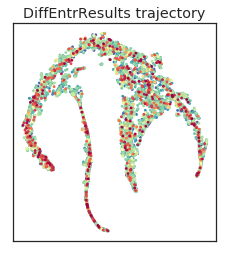

In [87]:
der.plot_palantir_on_tsne(tsne1)

alternatively, we will plot the tsne map colored by the different branch probabilities

ie. similar to the trajectory, make a tsne map each for each column of the branch probability matrix.

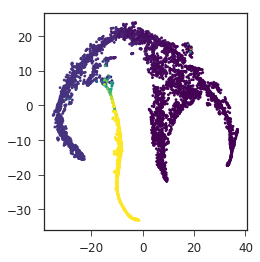

In [90]:
# column 0, Run4_235626713532342

fig = plt.figure(figsize=[8, 4])
gs = plt.GridSpec(1, 2)

ax = plt.subplot(gs[0, 1])
plt.scatter(tsne1['x'], tsne1['y'],
                edgecolors='none', s=8, 
                c=der.branch_prob.iloc[:,0])

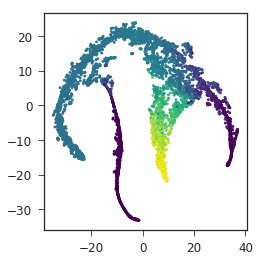

In [91]:
# column 1, Run5_161340154039083
fig = plt.figure(figsize=[8, 4])
gs = plt.GridSpec(1, 2)

ax = plt.subplot(gs[0, 1])
plt.scatter(tsne1['x'], tsne1['y'],
                edgecolors='none', s=8, 
                c=der.branch_prob.iloc[:,1])

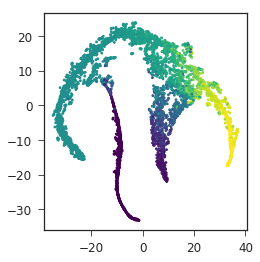

In [92]:
# column 2, Run5_239477254471070
fig = plt.figure(figsize=[8, 4])
gs = plt.GridSpec(1, 2)

ax = plt.subplot(gs[0, 1])
plt.scatter(tsne1['x'], tsne1['y'],
                edgecolors='none', s=8, 
                c=der.branch_prob.iloc[:,2])

<a id="ex"></a>
## Specific example
which shows the marker trends of the following genes: ['HBB', 'CD34', 'MPO', 'LYZ', 'CST3']

In [93]:
data_part = mb_data.loc[:,['HBB', 'CD34', 'MPO', 'LYZ', 'CST3']]

In [94]:
data_part

HBB      CD34       MPO       LYZ      CST3
Run4_120703408880541 -3.321928  0.171306 -3.321928  0.171306  2.645347
Run4_120703409056541 -3.321928  0.837003  0.837003 -3.321928 -3.321928
Run4_120703409580963 -3.321928 -3.321928  4.974236  6.386403  0.880299
Run4_120703423990708 -3.321928 -3.321928  5.063559  3.296390 -3.321928
Run4_120703424252854 -3.321928  0.538690 -3.321928 -0.365265 -3.321928
Run4_120703436876077 -3.321928 -3.321928  0.363786 -3.321928  0.363786
Run4_120703455025387 -3.321928 -0.270688 -0.270688 -3.321928 -3.321928
Run4_120726911638237 -3.321928  0.370883 -3.321928 -3.321928 -0.521655
Run4_120726912355038 -0.098613  0.822005  4.912722 -3.321928 -0.098613
Run4_120726924974443 -3.321928 -3.321928  4.006959 -0.910988 -0.053432
Run4_120726924978030 -3.321928  1.795234 -3.321928 -0.369327  0.534347
Run4_120726943295348 -3.321928 -3.321928  4.910699  6.399458  0.980907
Run4_120726943845302 -3.321928 -3.321928  5.758552  5.531596 -3.321928
Run4_120772961130853 -3.321928  1.221830 -3.321928 -3.321928  0.282395
Run4_120786758780660 -3.321928 -3.321928  0.047722 -3.321928 -3.321928
Run4_120786786086116 -3.321928 -3.321928  0.245224 -3.321928 -3.321928
Run4_120786804205803 -3.321928 -0.443817 -3.321928 -3.321928  0.454569
Run4_120786804401973 -3.321928  1.256403 -3.321928 -3.321928 -3.321928
Run4_120797898099934 -3.321928 -0.736818  5.070566  2.608983  0.678238
Run4_120797925428019 -3.321928  0.810766 -3.321928 -3.321928  0.810766
Run4_120797944278244 -0.569621  0.319141 -3.321928 -3.321928  2.041438
Run4_120797944309486 -3.321928 -3.321928 -3.321928 -0.597133  0.289401
Run4_120797944462237 -3.321928  1.986570 -3.321928 -3.321928 -3.321928
Run4_120797944538971 -3.321928  1.037736 -3.321928 -3.321928 -3.321928
Run4_120797945084765  1.128506 -3.321928 -3.321928 -3.321928 -3.321928
Run4_120864497952619 -3.321928 -3.321928  3.539276  5.588708  2.836658
Run4_121202296155437 -3.321928  0.065101 -0.803194 -0.803194  1.770428
Run4_121202296712412  0.731223 -3.321928  0.731223 -3.321928  1.687102
Run4_121202296875939 -3.321928  1.577101 -3.321928  0.624661 -3.321928
Run4_121202311609131  0.335232 -3.321928  4.975569  5.742348  2.246810
...                        ...       ...       ...       ...       ...
Run5_240634599983342 -3.321928 -3.321928  4.334501  3.686505  2.478976
Run5_240634599986987 -3.321928 -3.321928 -3.321928 -3.321928 -3.321928
Run5_240634613909861  4.089875 -3.321928 -3.321928 -0.505150  1.332478
Run5_240634614373595 -3.321928  1.461658  0.902651 -3.321928 -3.321928
Run5_240634614729955 -3.321928 -3.321928  5.754522  6.201268 -3.321928
Run5_240634626784550 -0.181935 -3.321928 -3.321928 -3.321928  2.002738
Run5_240634645855022 -3.321928 -3.321928 -3.321928 -3.321928  0.766502
Run5_240634646116662 -3.321928  2.060912 -3.321928 -3.321928 -3.321928
Run5_241057653508843 -3.321928 -3.321928 -3.321928 -3.321928  0.102278
Run5_241057653738918 -3.321928 -3.321928  5.097710  2.069387 -3.321928
Run5_241057654294885 -3.321928  2.651800 -3.321928 -3.321928 -3.321928
Run5_241057668712349 -3.321928  1.687102 -3.321928 -3.321928 -3.321928
Run5_241057680972510 -3.321928  0.131881  0.131881 -3.321928  0.131881
Run5_241057681259245 -3.321928 -3.321928  0.644397 -3.321928  2.166477
Run5_241057700113179 -3.321928  1.136287  0.200470 -3.321928  1.136287
Run5_241098858613659 -3.321928 -3.321928 -3.321928 -3.321928  0.729147
Run5_241098858810213 -3.321928 -3.321928  4.011044 -3.321928 -0.014261
Run5_241098873552118 -3.321928  1.030843 -3.321928 -3.321928 -3.321928
Run5_241098885647774 -3.321928 -0.357935 -3.321928 -3.321928  1.496269
Run5_241098904976174  0.841381 -0.080268 -3.321928 -3.321928 -3.321928
Run5_241098905205038 -3.321928  0.590031  0.590031 -3.321928  0.590031
Run5_241106375007076 -3.321928 -0.487455 -3.321928 -3.321928  1.662848
Run5_241106389756316 -3.321928  1.271771 -0.198384 -3.321928  1.984637
Run5_241106389784372 -0.212452 -0.212452 -3.321928 -0.212452 -0.212452
Run5_241106401770805 -3.321928  1.560339  0.070037 

In [95]:
der.compute_marker_trends(data_part, None, False, n_jobs=1)

Run4_235626713532342
Time for processing Run4_235626713532342: 0.00934739907582601 minutes
Run5_161340154039083
Time for processing Run5_161340154039083: 0.00717248519261678 minutes
Run5_239477254471070
Time for processing Run5_239477254471070: 0.007755351066589355 minutes


OrderedDict([('Run4_235626713532342',
                    0.000000  0.002004  0.004008  0.006012  0.008016  0.010020  0.012024  \
              HBB  -2.881165 -2.879282 -2.877399 -2.875515 -2.873632 -2.871748 -2.869862   
              CD34 -1.176626 -1.169043 -1.161460 -1.153878 -1.146299 -1.138722 -1.131151   
              MPO  -2.560854 -2.548371 -2.535887 -2.523402 -2.510917 -2.498430 -2.485942   
              LYZ  -2.696993 -2.696420 -2.695846 -2.695272 -2.694699 -2.694126 -2.693552   
              CST3 -1.006627 -1.009124 -1.011621 -1.014117 -1.016610 -1.019098 -1.021580   
              
                    0.014028  0.016032  0.018036    ...     0.981964  0.983968  0.985972  \
              HBB  -2.867975 -2.866085 -2.864190    ...     2.585900  2.667236  2.748667   
              CD34 -1.123585 -1.116026 -1.108477    ...    -2.545576 -2.565804 -2.586046   
              MPO  -2.473452 -2.460961 -2.448467    ...    -1.751219 -1.745355 -1.739491   
              LYZ  -2.69297

Run4_235626713532342
Time for processing Run4_235626713532342: 0.015826900800069172 minutes
Run5_161340154039083
Time for processing Run5_161340154039083: 0.01151425043741862 minutes
Run5_239477254471070
Time for processing Run5_239477254471070: 0.01206513245900472 minutes


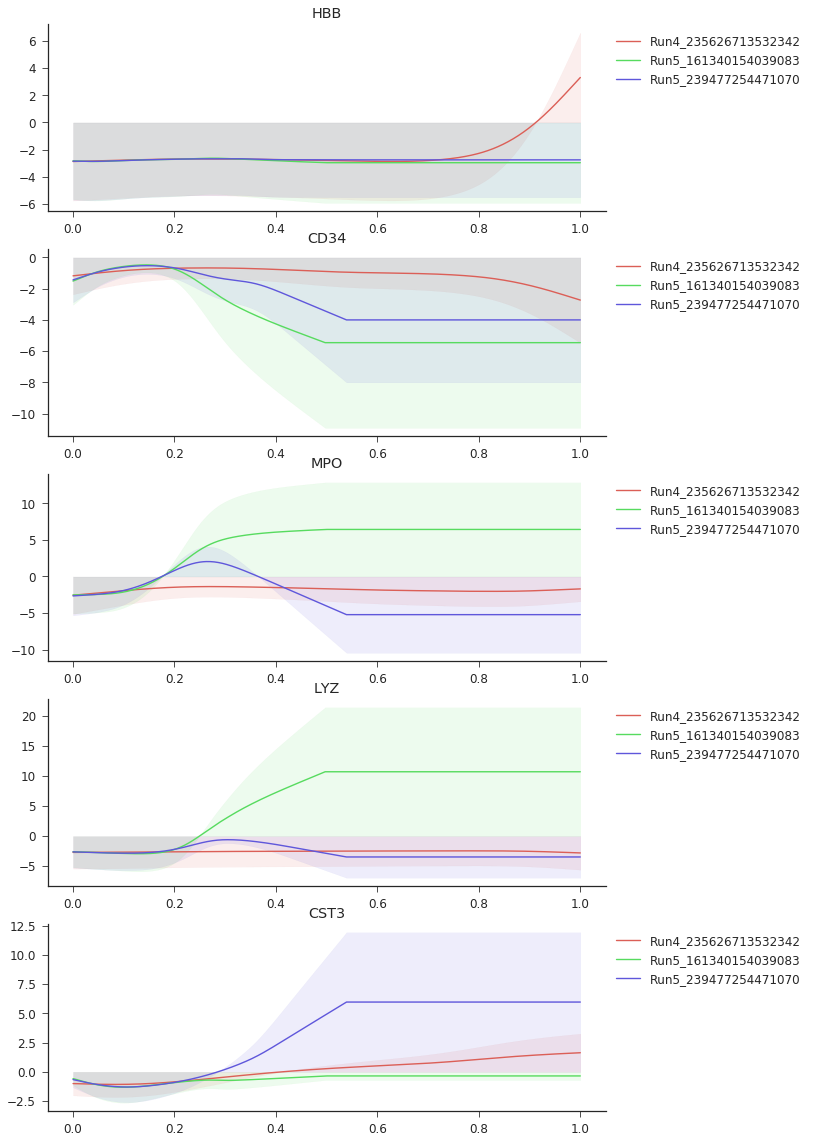

In [96]:
der.plot_markers(data_part)

### Comparison with trends.p...

In [97]:
trends = scanalysis.io.loadsave.load("~/trends.p")

Successfully loaded /Users/hjin/trends.p as a <class 'collections.OrderedDict'> object


In [98]:
trends

OrderedDict([('Run4_235626713532342',
                      0.000000  0.002004  0.004008  0.006012  0.008016  0.010020  0.012024  \
              KCTD15 -3.232311 -3.232019 -3.231727 -3.231436 -3.231144 -3.230853 -3.230562   
              STT3B  -2.121511 -2.114979 -2.108448 -2.101917 -2.095387 -2.088857 -2.082327   
              NAT6   -3.008021 -3.007220 -3.006418 -3.005616 -3.004814 -3.004011 -3.003208   
              FHL2   -3.080830 -3.077146 -3.073462 -3.069778 -3.066094 -3.062410 -3.058725   
              SP140L -3.010032 -3.008821 -3.007610 -3.006399 -3.005188 -3.003978 -3.002768   
              
                      0.014028  0.016032  0.018036    ...     0.981964  0.983968  0.985972  \
              KCTD15 -3.230271 -3.229980 -3.229691    ...    -2.702542 -2.702542 -2.702542   
              STT3B  -2.075798 -2.069270 -2.062743    ...    -1.747917 -1.747917 -1.747917   
              NAT6   -3.002405 -3.001601 -3.000795    ...    -2.920024 -2.920024 -2.920024   
       

<a id="ref"></a>
## References

Setty M, Tadmor MD, Reich-Zeliger S, Angel O, Salame TM, Kathail P, Choi K, Bendall S, Friedman N, Pe’er D. "Wishbone identifies bifurcating developmental trajectories from single-cell data." Nat. Biotech. 2016 April 12. <http://dx.doi.org/10.1038/nbt.3569>

van Dijk, David, et al. "MAGIC: A diffusion-based imputation method reveals gene-gene interactions in single-cell RNA-sequencing data." BioRxiv (2017): 111591. <http://www.biorxiv.org/content/early/2017/02/25/111591>

*Go back to top for [Table of Contents](#toc).*